### Introduction

This notebook is for performing transfer learning + fine tuning of the Leaf Classification problem.

First we connect to drive and locate the working directory

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/Colab\ Notebooks/ANN_DL2021/Project_1_Leaf_Classification/ANNDL_Challenge/
%ls

Mounted at /content/gdrive


### Import Libraries

In [10]:
import os
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm
import cv2

# Import library functions
import lib.utils as util
import lib.loaders as loaders
import lib.models as m

print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.7.0


### Get data

Here we assume that the dataset is in zip somewhere in the directory

In [11]:
if not os.path.exists("balanced_dataset"):
  !unzip balanced.zip -d balanced_dataset > /dev/null

In [12]:
%ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
balanced_dataset/
balanced.zip
Custom_CNN.ipynb
dataset.zip
DRTNet_TransferLearning_and_FineTuning.ipynb
Histories/
lib/
ToySubmission/
training/
transfer_learning_efficientnet.ipynb


### Set up data loader

The data loaders along with all preprocessing happens using library functions.

The specific functions used here can be found in 'lib/loaders/dataloader.py'

Found 15204 images belonging to 14 classes.
Found 1680 images belonging to 14 classes.


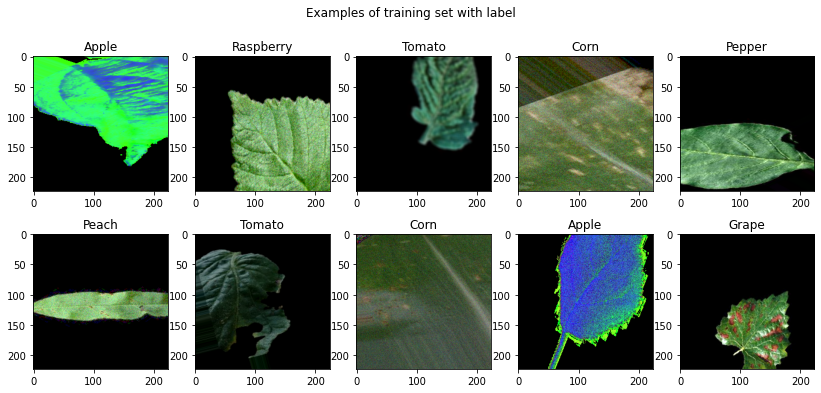

Data range: [ 0.0 , 1.0 ]


In [17]:
# Set directory
training_dir = 'balanced_dataset/balanced/'

# Set dataset parameters
batch_size = 16           # Batch size
IMG_SHAPE = (224,224,3)   # Image shape
validation_split = 0.1    # Split between train and validation
auglevel = 2              # The level of augmentation (0 is no augmentation) possible values: 0,1,2

# Fetch the data loaders
train_loader,val_loader = loaders.get_loaders(batch_size,IMG_SHAPE,validation_split,
                training_dir, auglevel, seed=seed)

# Visualize data
f,ax = util.visualize_data(train_loader)

### Build Transfer learning model

First we need to fetch the specific keras architecture we will be using as the transfer model. In this example notebook we use VGG19.

We need to get the model and its own preprocessing function

In [18]:
from tensorflow.keras.applications.vgg19 import preprocess_input
transfer_model = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation='softmax'
)

80150528/80134624 [==============================] - 1s 0us/step


Then we can build the model. Again this happens with a library function found in 'lib/models/transfer_models.py'

In [19]:
# Build model and view a summary
model = m.build_transfer_model(transfer_model, IMG_SHAPE, preprocess_input)
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

### Train the model

We define the number of epochs we would like to train and then train the model

In [20]:
epochs = 5

In [21]:
# Train the model
model_hist = model.fit(
    x = train_loader,
    epochs = epochs,
    validation_data = val_loader,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    verbose = 1
).history

Epoch 1/5
951/951 [==============================] - 378s 382ms/step - loss: 1.8275 - accuracy: 0.4088 - val_loss: 0.7797 - val_accuracy: 0.7315
Epoch 2/5
951/951 [==============================] - 355s 374ms/step - loss: 1.5368 - accuracy: 0.5001 - val_loss: 0.6399 - val_accuracy: 0.8131
Epoch 3/5
951/951 [==============================] - 357s 375ms/step - loss: 1.4736 - accuracy: 0.5147 - val_loss: 0.5815 - val_accuracy: 0.8179
Epoch 4/5
951/951 [==============================] - 346s 363ms/step - loss: 1.4401 - accuracy: 0.5285 - val_loss: 0.5712 - val_accuracy: 0.8375
Epoch 5/5
951/951 [==============================] - 352s 370ms/step - loss: 1.4115 - accuracy: 0.5362 - val_loss: 0.5635 - val_accuracy: 0.8143


We can then visualize some predictions on the validation set. 

(left is correct label and right is predicted label)

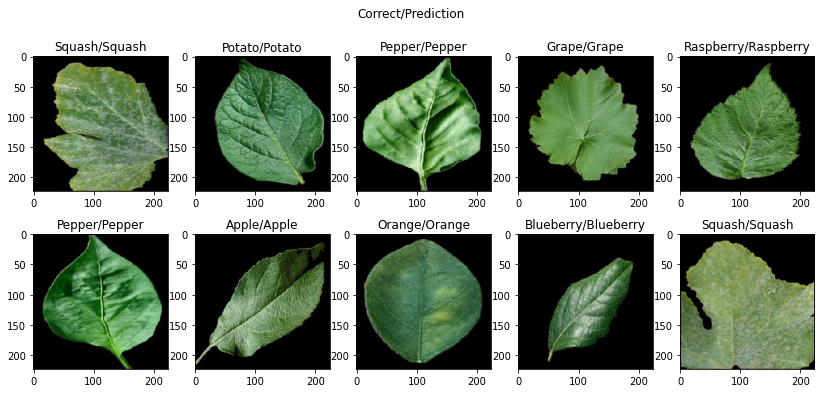

In [22]:
f,ax = util.visualize_predictions(model,val_loader)

If we need to we then save the model. That way we can continue later with the training/fine tuning

In [23]:
# model_path = "saved_models/"
# model_name = "vgg_aug2"
# model.save(model_path + model_name)
# np.save(model_path + model_name+"_hist.npy", model_hist) 

INFO:tensorflow:Assets written to: saved_models/vgg_aug2/assets


INFO:tensorflow:Assets written to: saved_models/vgg_aug2/assets


### Fine Tuning

We start by defining the model which we would like to work with.

Then we can load that model and its history

In [28]:
from keras.utils.layer_utils import count_params

# Define path and name
model_path = "saved_models/"
model_name = "vgg_aug2"
network = 'vgg19' # 'inception_v3' or 'vgg19'

# Load model
ft_model = tfk.models.load_model(model_path+model_name)

# Load history
old_hist = np.load(model_path + model_name+"_hist.npy",
                          allow_pickle='TRUE').item()

# See how many layers in the transfer part of the model
N_trainable = count_params(ft_model.trainable_weights)
N_layers = len(ft_model.get_layer(network).layers)
print("Transfer part has",N_layers,"layers")

Transfer part has 22 layers


For fine tuning we need to unfreeze some of the layers in the transfer part of the model. Here we unfreeze all but the first 3 layers

In [29]:
N = 3
ft_model.get_layer(network).trainable = True
for i, layer in enumerate(ft_model.get_layer(network).layers):
  if i < N:
    layer.trainable=False
assert count_params(ft_model.trainable_weights) > N_trainable
print("Model had  ",N_trainable,"trainable weights")
print("Now it has ",count_params(ft_model.trainable_weights),"trainable weights")

Model had   135438 trainable weights
Now it has  20121102 trainable weights


We then compile the model with the new changes and remember to use a lower learning rate

In [30]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
                  optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

The fine tuning then begins and we can train the model

In [31]:
# Number of epochs to tune model
tune_epochs = 1

In [32]:
ft_history = ft_model.fit(
    x = train_loader,
    epochs = tune_epochs,
    validation_data = val_loader,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
    verbose = 1
).history

# Combine the old and new histories
full_hist = util.combine_dicts(old_hist,ft_history)

951/951 [==============================] - 455s 474ms/step - loss: 1.0442 - accuracy: 0.6597 - val_loss: 0.1978 - val_accuracy: 0.9405


Then the resulting model and its history is saved

In [33]:
# ft_model.save(model_path+model_name+"_ft")
# np.save(model_path + model_name+"_ft_hist.npy", full_hist) 

INFO:tensorflow:Assets written to: saved_models/vgg_aug2_ft/assets


INFO:tensorflow:Assets written to: saved_models/vgg_aug2_ft/assets


### Test submission

This last section was made to chech that submissions would go through without any nasty error messages.

So the validation set is re-loaded, but without any rescaling (as if it was a test set from CodaLab)

Found 1680 images belonging to 14 classes.


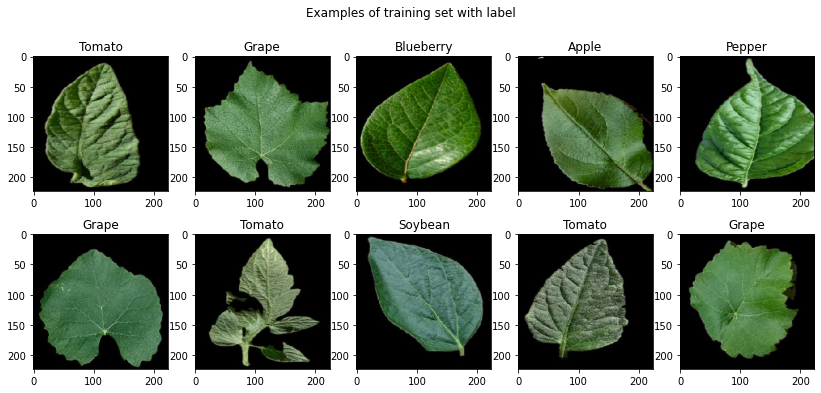

Data range: [ 0.0 , 255.0 ]


In [35]:
val_loader_sub = loaders.get_submission_loader(batch_size,IMG_SHAPE,validation_split,
                training_dir, seed=seed)

# Visualize data
f,ax = util.visualize_data(val_loader_sub)
plt.show()

Then the submission class that will be used for submissions are defined

In [36]:
import os
import tensorflow as tf

class submission_model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'vgg_aug2_ft'))

    def predict(self, X):
        
        # Insert your preprocessing here
        X = tf.image.resize(X, (224, 224))
        X = X/255.

        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)

        return out

In [37]:
# Path to saved model
path = "saved_models/"

# Load model
submodel = submission_model(path)

The submission model is then tested on the validation set. The goal is to have the exact same error as in the training phase.

In [39]:
# Compute confusion matrix
cm = util.compute_confusion_matrix(submodel, val_loader_sub)

# Compute accuracy
acc = np.sum(np.diag(cm))/np.sum(cm)
print("\nAccuracy :",acc)

Running : 100%|██████████| 105/105 [00:28<00:00,  3.74it/s]


Accuracy : 0.9416666666666667


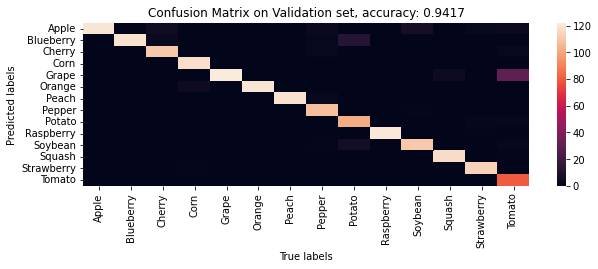

In [40]:
# Plot confusion matrix
f,ax = util.plot_confusion_matrix(cm, normalize = False, show = False)
ax.set_title("Confusion Matrix on Validation set, accuracy: "+str(round(acc,4)))
plt.show()